# Starter Notebook for GeneTuring Few-shot Evaluation

Let's start of by implementing a basic harness to evaluate the Geneturing dataset using Ollama with a Few-Shot prompting strategy to evaluate the performance of these models before implementing the tool-using strategies outlined in the GeneGPT paper.

As with most benchmarking code using pretrained models, our notebook will following typical outline of:

1. **Imports**
2. **Configuration**
3. **Data Loading**
4. **Model Specification**
5. **Metrics**
6. **Evaluation Loop**
7. **Analysis**

## 1. Imports

Good hygiene for Jupyter notebooks includes placing all of the imports at the top of the notebook. This makes it easier to understand what dependencies are needed to run the notebook for new users and mirrors good practices for Python scripts.

In [ ]:
from dotenv import load_dotenv
import os
import mlflow

os.environ["no_proxy"] = "*"

mlflow.set_tracking_uri("http://198.215.61.34:8153/")
mlflow.set_experiment("s440708_Shiqiu")
load_dotenv()

AZURE_OPENAI_KEY = os.getenv("AZURE_OPENAI_KEY")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_DEPLOYMENT_NAME = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")
AZURE_OPENAI_API_VERSION = os.getenv("AZURE_OPENAI_API_VERSION")

print("Loaded API key:", AZURE_OPENAI_KEY[:5] + "..." if AZURE_OPENAI_KEY else "MISSING")


Loaded API key: FJ5Gr...


In [2]:
from typing import List, Dict, Optional

from collections import defaultdict
from dataclasses import dataclass


## 2. Configuration

Also, let's create a section that is specific to the configuration of the run. This will make it easier to change the configuration of the run without hunting for hard-coded values sprinkled throughout the code and makes it easier for others to understand the configuration of the run.

We will leave it empty at the moment, but we will come back and fill it in as we identify global configuration options that we need to implement the code.

In [26]:
# 2.1 Data Configuration
data_config = {
    "dataset_path": "/work/bioinformatics/s440708/MODULE_3_MATERIALS/data/genehop.json",  
    "output_path": "/work/bioinformatics/s440708/MODULE_3_MATERIALS/outputs/",

}


In [4]:
# 2.2 Model Configuration

model_config = {           
    "model_name": AZURE_OPENAI_DEPLOYMENT_NAME,         
    'frequency_penalty': 0.0,
    'presence_penalty': 0.0,
    "temperature": 1.,
    "max_tokens": 800,
    "top_p": 1.0,
    
}


## 3. Data Loading

In this section we need to load the data that we will be using for our evaluation. 

The JSON file at `data/gene_turing.json` contains a dictionary of dictionaries. At the top level, the keys are the names of the tasks. Within each task, there are several key-value pairs where the keys are the questions and the values are the answers.

Below is one example for each of the 9 tasks in the dataset:

```json
{
    "Gene alias": {
        "What is the official gene symbol of LMP10?": "PSMB10"
    },
    "Gene disease association": {
        "What are genes related to Hemolytic anemia due to phosphofructokinase deficiency?": "PFKL"
    },
    "Gene location": {
        "Which chromosome is FAM66D gene located on human genome?": "chr8"
    },
    "Human genome DNA aligment": {
        "Align the DNA sequence to the human genome:ATTCTGCCTTTAGTAATTTGATGACAGAGACTTCTTGGGAACCACAGCCAGGGAGCCACCCTTTACTCCACCAACAGGTGGCTTATATCCAATCTGAGAAAGAAAGAAAAAAAAAAAAGTATTTCTCT": "chr15:91950805-91950932",
    },
    "Multi-species DNA aligment": {
        "Which organism does the DNA sequence come from:AGGGGCAGCAAACACCGGGACACACCCATTCGTGCACTAATCAGAAACTTTTTTTTCTCAAATAATTCAAACAATCAAAATTGGTTTTTTCGAGCAAGGTGGGAAATTTTTCGAT": "worm",
    },
    "Gene name conversion": {
        "Convert ENSG00000215251 to official gene symbol.": "FASTKD5",
    },
    "Protein-coding genes": {
        "Is ATP5F1EP2 a protein-coding gene?": "NA",
    },
    "Gene SNP association": {
        "Which gene is SNP rs1217074595 associated with?": "LINC01270",
    },
    "SNP location": {
        "Which chromosome does SNP rs1430464868 locate on human genome?": "chr13",
    }
}
```


We need to reformat this into a pandas dataframe with the following columns:
- `id`: A serial ID number we will assign to each example (int)
- `task`: The name of the task (str)
- `question`: The question for the example (str)
- `answer`: The answer for the example (str)

The final dataframe we will create should look like this:

| id | task | question | answer |
|----|------|----------|--------|
| 0 | Task1 | Question1 | Answer1 |
| 1 | Task1 | Question2 | Answer2 |
| 2 | Task2 | Question1 | Answer1 |
| 3 | Task2 | Question2 | Answer2 |

In [6]:
# 3.1 Load the JSON file
# Load the data here
import json

def load_geneturing(path: str) -> List[Dict[str, str]]:
    with open(path, "r") as f:
        raw_data = json.load(f)

    flat_data = []
    counter = 0
    for task_name, qa_pairs in raw_data.items():
        for question, answer in qa_pairs.items():
            flat_data.append({
                "task": task_name,
                'id': counter,
                "question": question,
                "answer": answer
            })
            counter += 1
    

    return flat_data


# config = Config()
dataset = load_geneturing(data_config['dataset_path'])
print(f"Loaded {len(dataset)} examples from {data_config['dataset_path']}")
TASKS = set() 

Loaded 150 examples from /work/bioinformatics/s440708/MODULE_3_MATERIALS/data/genehop.json


In [7]:
dataset

[{'task': 'sequence gene alias',
  'id': 0,
  'question': "What are the aliases of the gene that contains this sequnece:GTAGATGGAACTGGTAGTCAGCTGGAGAGCAGCATGGAGGCGTCCTGGGGGAGCTTCAACGCTGAGCGGGGCTGGTATGTCTCTGTCCAGCAGCCTGAAGAAGCGGAGGCCGA. Let's decompose the question to sub-questions and solve them step by step.",
  'answer': ['SLC38A6', 'NAT-1', 'SNAT6']},
 {'task': 'sequence gene alias',
  'id': 1,
  'question': "What are the aliases of the gene that contains this sequnece:ATTGTGAGAGTAACCAACGTGGGGTTACGGGGGAGAATCTGGAGAGAAGAGAAGAGGTTAACAACCCTCCCACTTCCTGGCCACCCCCCTCCACCTTTTCTGGTAAGGAGCCC. Let's decompose the question to sub-questions and solve them step by step.",
  'answer': ['FCGR3A',
   'CD16',
   'FCG3',
   'CD16A',
   'FCGR3',
   'IGFR3',
   'IMD20',
   'FCR-10',
   'FCRIII',
   'CD16-II',
   'FCGRIII',
   'FCRIIIA',
   'FcGRIIIA']},
 {'task': 'sequence gene alias',
  'id': 2,
  'question': "What are the aliases of the gene that contains this sequnece:GGAAGAGGCCCCAGCACTGACCTCCGTGGGGGTG

In [8]:
# 3.2 Iterate through the JSON data recursively to collect each of the rows into a list
#     Each row should have a dictionary with keys of the columsn in the table above


# def flatten_geneturing_json(raw_data) -> List[Dict[str, str]]:

#     flat_data = []
#     counter = 0

#     for  in raw_data:
#         for question, answer in qa_pairs.items():
#             row = {
#                 "id": counter,
#                 "task": task_name,
#                 "question": question,
#                 "answer": answer
#             }
#             flat_data.append(row)
#             counter += 1

  

#     return flat_data

# dataset = flatten_geneturing_json(dataset)
# print(f"Flattened to {len(dataset)} rows.")


In [9]:
# 3.3 Create the pandas dataframe from the collection of rows

import pandas as pd

def build_dataframe(flat_data: List[Dict[str, str]]) -> pd.DataFrame:

    df = pd.DataFrame(flat_data)
    
    df = df[["id", "task", "question", "answer"]]  
    df.set_index("id", inplace=True)
    return df

df = build_dataframe(dataset)
print(f"DataFrame shape: {df.shape}")
display(df.head())

DataFrame shape: (150, 3)


,task,question,answer
id,,,
0,sequence gene alias,What are the aliases of the gene that contains...,"[SLC38A6, NAT-1, SNAT6]"
1,sequence gene alias,What are the aliases of the gene that contains...,"[FCGR3A, CD16, FCG3, CD16A, FCGR3, IGFR3, IMD2..."
2,sequence gene alias,What are the aliases of the gene that contains...,"[FNDC11, C20orf195]"
3,sequence gene alias,What are the aliases of the gene that contains...,"[EOLA2, CXorf40B]"
4,sequence gene alias,What are the aliases of the gene that contains...,"[PSMB10, LMP10, MECL1, PRAAS5, beta2i]"


## 4. Model Specification

With our few-shot in-context learning model, we need to specify four components:

1. The large language model to use
2. The instructions for the model as a system prompt
3. The few-shot examples to provide to the model to demonstrate the input-output format
4. The completion request function that puts it all together retrieving a response for each unseen input

### 4.1 Setting up the large language model

We will use the Ollama client to interface with the large language model on the Ollama server we started. With large language models, it is common to use a client library to interface with the model hosted by a server. This allows us to iterate quickly on the prompting and post-processing logic without having to incur the overhead of loading the model into memory each time.  Additionally, model code is oftentimes optimized for inference.

In [ ]:
os.environ['no_proxy'] = '*'

from ollama import Client
client = Client(
  host='http://172.18.224.42:11434',
)
response = client.chat(model='qwen3:4b', messages=[
  {
    'role': 'user',
    'content': 'Why is the sky blue?',
  },
])

In [51]:
response['message'].content

"<think>\nOkay, the user is asking why the sky is blue. I remember that this is a classic question in physics. Let me think about the correct explanation.\n\nFirst, I recall that sunlight is white, but it's actually a mixture of all the colors in the visible spectrum. When sunlight enters Earth's atmosphere, it interacts with the molecules and small particles in the air. The key here is Rayleigh scattering, which is the scattering of light by particles much smaller than the wavelength of the light.\n\nBlue light has a shorter wavelength compared to other colors like red or yellow. Because of this, blue light is scattered more efficiently by the molecules in the atmosphere. So when sunlight reaches the Earth, the blue light is scattered in all directions, making the sky appear blue during the day.\n\nBut wait, I should check if there are other factors. For example, during sunrise or sunset, the sky appears red or orange. That's because the sunlight has to pass through more of the atmosp

In [ ]:
# 4.1 Setting up the large language model Ollama model client
from openai import AzureOpenAI

OllamaClient = AzureOpenAI(
    api_version=AZURE_OPENAI_API_VERSION,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_KEY,
)

response = OllamaClient.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant.",
        },
        {
            "role": "user",
            "content": "I am going to Paris, what should I see?",
        }
    ],
   
    max_completion_tokens=model_config['max_tokens'],
    temperature=model_config['temperature'],
    top_p=model_config['top_p'],
    frequency_penalty=model_config['frequency_penalty'],
    presence_penalty=model_config['presence_penalty'],
    model=model_config['model_name']

)

print(response.choices[0].message.content)


That’s exciting! Paris is full of iconic sights, rich culture, and mouthwatering food. Here’s a list of must-see attractions and experiences to consider:

**Classic Landmarks**
1. **Eiffel Tower** – Go up for panoramic city views, especially stunning at sunset or after dark when it sparkles.
2. **Louvre Museum** – Home to the Mona Lisa and countless masterpieces. Even if not a big art fan, the building itself is beautiful.
3. **Notre-Dame Cathedral** – Currently under restoration, but the exterior and the neighboring Ile de la Cité are still a must-visit.
4. **Arc de Triomphe** – Climb to the top for great views of the Champs-Élysées and Paris’ many grand avenues.
5. **Sacré-Cœur Basilica** in Montmartre – Marvel at the mosaics inside and enjoy sweeping vistas of Paris outside.

**Neighborhoods to Explore**
- **Le Marais** – Chic boutiques, galleries, Jewish heritage sites, and cozy cafes.
- **Montmartre** – Bohemian flair, art history, and charming streets.
- **Latin Quarter** – Bustl

### 4.2 Setting up the system prompt

Modern large language models are post-trained to perform a variety of tasks and follow instructions. To leverage this capability, we need to provide a system prompt that clearly outlines the task, any constraints, and the format of the output.

Designing the system prompt is a critical aspect of using LLMs. Below are several resources for designing a system prompt:
* [OpenAI Prompt Engineering](https://platform.openai.com/docs/guides/text?api-mode=responses#prompt-engineering)
* [Kaggle/Google Prompt Engineering](https://www.kaggle.com/whitepaper-prompt-engineering?_bhlid=a2bfce2cac67662098bd85a241e7cb000576e5d4)
* [Anthropic Prompt Engineering](https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/overview)
* [OpenAI GPT 4.1 Prompting Cookbook](https://cookbook.openai.com/examples/gpt4-1_prompting_guide)


**From the OpenAI Prompt Engineering guide:**

> **Identity**: Describe the purpose, communication style, and high-level goals of the assistant. 
> 
> **Instructions**: Provide guidance to the model on how to generate the response you want. What rules should it follow? What should the model do, and what should the model never do? This section could contain many subsections as relevant for your use case, like how the model should call custom functions.  
>
> **Examples**: Provide examples of possible inputs, along with the desired output from the model.  
> 
> **Context**: Give the model any additional information it might need to generate a response, like private/proprietary data outside its training data, or any other data you know will be particularly relevant. This content is usually best positioned near the end of your prompt, as you may include different context for different generation requests.  

This is what the system prompt looked like in the originalGeneGPT paper, but it is not the best. Identify what it includes and what is missing. Implement your own system prompt incorporating best practices from some of the guides posted above. 

> 	'Hello. Your task is to use NCBI Web APIs to answer genomic questions.'

In [ ]:
# 4.2 Draft your own system prompt for our generic genomics question answering system. 
#     Replace the system message `content` below with your own.
system_message = [
    {
        "role": "system",
        "content": 'Hello. Your task is to use NCBI Web APIs to answer genomic questions.',
        
    }
]

### 4.3 Setting up the few-shot examples

For tasks with idiosyncratic output formats or constraints, it is important to provide clear instructions as well as examples to guide the model in generating the desired output. Mechanically, we provide these pairs of inputs and outputs as a sequence of user and assistant messages after the system prompt.

```python
messages += [
    {
        "role": "user",
        "content":  <fill in input example 1>
    },
    {
        "role": "assistant",
        "content": <fill in output example 1>
    },
    {
        "role": "user",
        "content": <fill in input example 2>
    },
    {
        "role": "assistant",
        "content": <fill in output example 2>
    }
]
```

In the GeneGPT code, the authors included several tasks, one of each of a subset of the tasks in the dataset. We will use the same examples here.

Please inspect the GeneGPT repository to find the few-shot examples in the prompt. 

Specifically the `get_prompt_header` function in `main.py` located here: [main.py](https://github.com/ncbi/GeneGPT/blob/main/main.py)

In [ ]:
# 4.3 Appending the few-shot examples to the `messages` list
few_shot_examples = [
    {"role": "user", "content": "What are the aliases of the gene that contains this sequnece:"
     "ACTTCCAACATGGCGGCGGCCGGGGCGGCGGTGGCGCGCAGCCCGGGAATCGGAGCGGGACCTGCGCTGAGAGCCCGGCGCTCGCCCCCGCCGCGGGCCGCACGGCTGCCGCG."
     "Let's decompose the question to sub-questions and solve them step by step."},
    {"role": "assistant", "content": "QSOX2, SOXN, QSCN6L1"},
    {"role": "user", "content": "List chromosome locations of the genes related to Hemolytic anemia due to phosphofructokinase deficiency. Let's decompose the question to sub-questions and solve them step by step."},
    {"role": "assistant", "content": "21q22.3"},
    {"role": "user", "content": "What is the function of the gene associated with SNP rs1217074595? Let's decompose the question to sub-questions and solve them step by step."},
    {"role": "assistant", "content": "ncRNA"}
]



### 4.4 Implementing the model request function

Now we need to put it all together. We need a function that accepts as arguments:
1. The client
2. The system message
3. The few-shot examples
4. The new user query -- this case the user's question from the GeneTuring dataset.

The function should return the response from the model and extract the answer (everything after 'Answer :' based on the format of the examples above)



In [ ]:
from ollama import chat
from pydantic import BaseModel

def query_model(
    client,  
    system_message: dict,
    few_shot_examples: List[dict],
    user_query: str,
) -> str:
    
    messages = [system_message] + few_shot_examples + [{"role": "user", "content": user_query}]

    # response = client.chat.completions.create(
    #     model=model_config['model_name'],
    #     messages=messages,
    #     max_tokens=model_config['max_tokens'],
    #     temperature=model_config['temperature'],
    #     top_p=model_config['top_p'],
    #     frequency_penalty=model_config['frequency_penalty'],
    #     presence_penalty=model_config['presence_penalty'],
    # )
    # client = Client(
    #     host='http://172.18.224.42:11434',
    # )
    response = client.chat(model='qwen3:4b', messages=messages)
    
    response = chat(
        messages=messages,
        model='llama3.1',
        format=Diagnosis.model_json_schema(),
    )
    return response['message'].content
    #return response.choices[0].message.content


## 5. Metrics

The GeneTuring dataset has several task specific evaluation metrics that are variations on exact match depending on the expected cardinality of the output.

Please inspect `evaluate.py` from the GeneGPT repository to find the metric functions and implement them here.

Original functions: [evaluate.py](https://github.com/ncbi/GeneGPT/blob/main/evaluate.py)

* **Default exact match** - The predicted answers and ground truth are both strings. The score is 1 if they are equal and 0 otherwise
* **Gene disease association** - The predicted answers and ground truth are both lists of gene-disease associations. The score is the proportion of correct associations present in the prediction
* **Disease gene location** - The predicted and true answers are lists (e.g., gene locations related to a disease), and the evaluation calculates the fraction of the correct items present in the prediction.
* **Human genome DNA aligment** - 1 point for exact match, 0.5 point if chrX part matches, 0 otherwise

In [59]:
# 5.1 Implement metrics

def exact_match(pred: str, true: str) -> float:
    # if isinstance(pred, list):
    #     pred = [p.strip().lower() for p in pred]
    #     return float(true.strip().lower() in pred)
    # else:
    #     return float(pred.strip().lower() == true.strip().lower())
    return float(pred.strip().lower() == true.strip().lower())


def gene_disease_association(pred: list, true: list) -> float:
    pred_set = set(map(str.lower, map(str.strip, pred)))
    true_set = set(map(str.lower, map(str.strip, true)))
    if not true_set:
        return 1.0 if not pred_set else 0.0
    return len(pred_set & true_set) / len(true_set)

def disease_gene_location(pred: list, true: list) -> float:
    pred_set = set(map(str.lower, map(str.strip, pred)))
    true_set = set(map(str.lower, map(str.strip, true)))
    if not true_set:
        return 1.0 if not pred_set else 0.0
    return len(pred_set & true_set) / len(true_set)
    
def human_genome_dna_alignment(pred: str, true: str) -> float:
    pred = pred.strip().lower()
    true = true.strip().lower()
    if pred == true:
        return 1.0
    pred_chr = pred.split(':')[0]
    true_chr = true.split(':')[0]
    return 0.5 if pred_chr == true_chr else 0.0

metric_task_map = defaultdict(lambda: exact_match, {
    "Gene disease association": gene_disease_association,
    "Gene location": disease_gene_location,
    "Human genome DNA aligment": human_genome_dna_alignment
})


Many of the gold-answers are in a specific format. `evaluate.py` also implements an answer post-processing function `get_answer` to better align model outputs with the gold answers. We also need to implement a similar function.

In [60]:
def get_answer(answer, task):

	mapper = {'Caenorhabditis elegans': 'worm',
			  'Homo sapiens': 'human',
			  'Danio rerio': 'zebrafish',
			  'Mus musculus': 'mouse',
			  'Saccharomyces cerevisiae': 'yeast',
			  'Rattus norvegicus': 'rat',
			  'Gallus gallus': 'chicken'}

	if task == 'SNP location':
		answer = answer.strip().split()[-1]
		if 'chr' not in answer:
			answer = 'chr' + answer

	elif task == 'Gene location':
		answer = answer.strip().split()[-1]
		if 'chr' not in answer:
			answer = 'chr' + answer

	elif task == 'Gene disease association':
		answer = answer.strip().replace('Answer: ', '')
		answer = answer.split(', ')

	elif task == 'Disease gene location':
		answer = answer.strip().replace('Answer: ', '')
		answer = answer.split(', ')

	elif task == 'Protein-coding genes':
		answer = answer.strip().replace('Answer: ', '')
		if answer == 'Yes':
			answer = 'TRUE'
		elif answer == 'No':
			answer = 'NA'

	elif task == 'Multi-species DNA aligment':
		answer = answer.strip().replace('Answer: ', '')
		answer = mapper.get(answer, answer)

	else:
		answer = answer.strip().replace('Answer: ', '')
		
	return answer


## 6. Evaluation Loop

Now, let's implement the evaluation loop for the GeneTuring dataset. For now we will call the model function one at a time and collect the results in a list. Also, we will collect per-task metrics and the overall metrics for the dataset as we go. Once we're done, we will save the results to a CSV file.

In [61]:
# 6.1 Set up data structures for results
from dataclasses import asdict

@dataclass
class Result:
    id: int
    task: str
    question: str
    answer: str
    raw_prediction: Optional[str]
    processed_prediction: Optional[str]
    score: Optional[float]
    success: bool


def save_results(results: List[Result], results_csv_filename: str) -> None:
    df = pd.DataFrame([asdict(r) for r in results])
    df.to_csv(results_csv_filename, index=False)



In [ ]:
# 6.2 Loop over the dataset with a progress bar

# * Do not forget to add the results to our Result list, both successful and failed predictions
# * API calls will not always work, so make sure we capture the exceptions from failed calls
#    and add them to the Result list with a `status=False`

from tqdm import tqdm
from typing import Any, Callable, Dict, List, Optional, Union, cast

def evaluate_with_progress(
    client: Any,
    dataset: List[Dict[str, str]],
    system_message: Dict[str, str],
) -> List[Result]:
    results: List[Result] = []
    results = []
    with mlflow.start_run(run_name="geneturing-eval"):
        mlflow.log_param("model", model_config["model_name"])
        mlflow.log_param("temperature", model_config["temperature"])
        mlflow.log_param("max_tokens", model_config["max_tokens"])
        mlflow.log_param("top_p", model_config["top_p"])

        for item in tqdm(dataset, desc="Evaluating"):
            item_id = item.get("id")
            task = item.get("task")
            question = item.get("question")
            gold_answer = item.get("answer")

            try:
                raw_pred = query_model(
                    client, system_message, question
                )
                # pred = get_answer(raw_pred, task)
                # true = get_answer(gold_answer, task)
                # metric_fn = metric_task_map[task]
                # score = metric_fn(pred, true)
                # print("raw_pred:", raw_pred)
                # print("pred", pred)
                # print("true", true)
                # print("Task", task)
                # result = Result(
                #     id=item_id,
                #     task=task,
                #     question=question,
                #     answer=gold_answer,
                #     raw_prediction=raw_pred,
                #     processed_prediction=str(pred),
                #     score=score,
                #     success=True,
                # )

            except Exception:
                result = Result(
                    id=item_id,
                    task=task,
                    question=question,
                    answer=gold_answer,
                    raw_prediction=None,
                    processed_prediction=None,
                    score=0.0,
                    success=False,
                )

            results.append(result)

        # Calculate and log metrics
        df = pd.DataFrame([asdict(r) for r in results])
        success_rate = df["success"].mean()
        valid_scores_df = df[df["score"].notna()]
        overall_score = valid_scores_df["score"].mean()

        mlflow.log_metric("success_rate", success_rate)
        mlflow.log_metric("overall_score", overall_score)

        for task_name, task_df in valid_scores_df.groupby("task"):
            mlflow.log_metric(
                f"score_{task_name.replace(' ', '_')}", task_df["score"].mean()
            )

        # Save to CSV and log as artifact
        
        result_csv_path = os.path.join(data_config['output_path'], "genehop_results.csv")
        df.to_csv(result_csv_path, index=False)
        mlflow.log_artifact(result_csv_path)

    return results
# def evaluate_with_progress(
#     client,
#     dataset: List[Dict],
#     system_message: Dict,
#     few_shot_examples: List[Dict],
# ) -> List[Result]:
#     results: List[Result] = []

#     for item in tqdm(dataset, desc="Evaluating"):
#         item_id = item.get("id")
#         task = item.get("task")
#         question = item.get("question")
#         gold_answer = item.get("answer")


    
#         raw_pred = query_model(client, system_message, few_shot_examples, question)

#         # Post-process
#         print("task:", task)
#         # print("raw pred:", raw_pred)
#         pred = get_answer(raw_pred, task)
#         print("pred:", pred)
#         true = get_answer(gold_answer, task)
#         print("true:",true)


#         metric_fn = metric_task_map[task]
#         score = metric_fn(pred, true)
#         try:
#             result = Result(
#                 id=item_id,
#                 task=task,
#                 question=question,
#                 answer=gold_answer,
#                 raw_prediction=raw_pred,
#                 processed_prediction=str(pred),
#                 score=score,
#                 success=True
#             )

#         except Exception:
        
#             result = Result(
#                 id=item_id,
#                 task=task,
#                 question=question,
#                 answer=gold_answer,
#                 raw_prediction=None,
#                 processed_prediction=None,
#                 score=0.0,
#                 success=False
#             )

#         results.append(result)

#     return results


In [52]:
# 6.3 Save the results
import random


sample = random.sample(dataset, 50)

results = evaluate_with_progress(client, sample, system_message[0], few_shot_examples)
#save_results(results, os.path.join(data_config['output_path'], "genehop_results.csv"))


Evaluating: 100%|██████████| 50/50 [00:00<00:00, 166970.70it/s]

🏃 View run geneturing-eval at: http://198.215.61.34:8153/#/experiments/9/runs/258221a68f724e5f8e900341e624db60
🧪 View experiment at: http://198.215.61.34:8153/#/experiments/9


## 7. Analysis

Now that we have collected the first round of GeneTuring results, let's analyze them. Let's start by calculating what fraction of predictions were successful.

In [53]:
import pandas as pd

df = pd.read_csv(os.path.join(data_config['output_path'], "genehop_results.csv"))
success_rate = df['success'].mean()
print(f"Fraction of successful predictions: {success_rate:.2%}")


Fraction of successful predictions: 0.00%


Now let's calculate both the overall score as well as the score by task.

In [31]:
# 7.2 Calculate the overall score and the score by task

valid_scores_df = df[df['score'].notna()]
overall_score = valid_scores_df['score'].mean()
score_by_task = valid_scores_df.groupby('task')['score'].mean()
print(f"Overall average score: {overall_score:.3f}\n")
print("Score by task:")
print(score_by_task)


Overall average score: 0.000

Score by task:
task
Disease gene location    0.0
SNP gene function        0.0
sequence gene alias      0.0
Name: score, dtype: float64


Then, let's create a bar chart of the scores by task with a horizontal line for the overall score. Let's save the figure as well to our output directory.

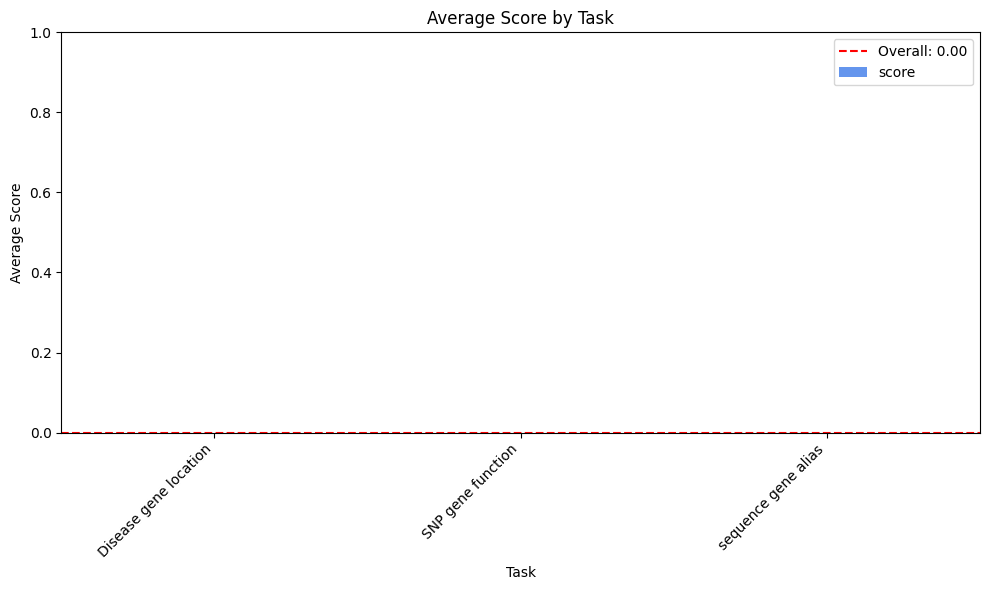

In [32]:
# 7.3 Create a bar chart of the scores by task with a horizontal line for the overall score
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
score_by_task.plot(kind='bar', color='cornflowerblue')
plt.axhline(y=overall_score, color='red', linestyle='--', label=f'Overall: {overall_score:.2f}')
plt.title("Average Score by Task")
plt.xlabel("Task")
plt.ylabel("Average Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

